## 8. Model Diagnostics

**Exercise 8.1**.  For an AR(1) model with $\phi \approx 0.5$ and $n = 100$, the lag 1 sample autocorrelation of the residuals is 0.5.  Should we consider this unusual?  Why or why not?

**Solution**.  From Equation (8.1.5),

$$ \text{Var}[\hat{r}_1] \approx \frac{\phi^2}{n} $$

so the standard error of the sample correlation to be approximately 0.05, and we should expect the lag 1 sample autocorrelation to be within 2 standard errors, $\pm 0.1$.  A value of 0.5 is unusual.

**Exercise 8.2**.  Repeat Exercise 8.1 for an MA(1) model with $\theta \approx 0.5$ and and $n = 100$.

**Solution**.  Page 183 indicates that we can replace $\phi$ with $\theta$ for MA(1) models, so

$$ \text{Var}[\hat{r}_1] \approx \frac{\theta^2}{n} $$

Once again the standard error of the sample correlation is approximately 0.05, and we should expect the lag 1 sample autocorrelation to be within 2 standard errors, $\pm 0.1$.  A value of 0.5 is unusual.

**Exercise 8.3**.  Based on a series of length $n = 200$, we fit an AR(2) model and obtain residual autocorrelations of $\hat{r}_1 = 0.13$, $\hat{r}_2 = 0.13$, and $\hat{r}_3 = 0.12$.  If $\hat{\phi}_1 = 1.1$ and $\hat{\phi}_2 = −0.8$, do these residual autocorrelations support the AR(2) specification?  Individually  Jointly?

**Solution**.  Equations (8.1.8), (8.1.9) and (8.1.10) state that, for the AR(2) model,

$$
\text{Var}[\hat{r}_1] \approx \frac{\phi_2^2}{n},
\quad
\text{Var}[\hat{r}_2] \approx \frac{\phi_2^2 + \phi_1^2(1 + \phi_2)^2}{n},
\quad
\text{Var}[\hat{r}_k] \approx \frac{1}{n} \quad \text{for } k \geq 3
$$

Replacing in the given values, we get

$$
2 \sqrt{\text{Var}[\hat{r}_1]} \approx 0.113,
\quad
2 \sqrt{\text{Var}[\hat{r}_2]} \approx 0.117,
\quad
2 \sqrt{\text{Var}[\hat{r}_k]} \approx 0.141 \quad \text{for } k \geq 3
$$

The residual autocorrelations for $\hat{r}_1$ and $\hat{r}_2$ are above those thresholds, while the residual autocorrelation for $\hat{r}_3$ is under the corresponding threshold.

The Ljung-Box statistic is

$$ Q_* = n(n+2) \left( \frac{\hat{r}_1^2}{n - 1} + \frac{\hat{r}_2^2}{n - 2} + \frac{\hat{r}_3^2}{n - 3} \right) $$

which, replacing values, gives $Q_* \approx 9.832$.  If the AR(2) speficication is correct, then $Q_*$ should have approximately a chi-square distribution with 3 - 2 = 1 degree of freedom.  But $\text{Pr}[\chi_1^2 > Q_*] \approx 0.0017$, so the residual correlations are jointly too large to support the AR(2) specification at p-value 0.01.

In [1]:
n = 200
r1, r2, r3 = 0.13, 0.13, 0.12
Qstar = n * (n + 2) * (r1**2/(n-1) + r2**2/(n-2) + r3**2/(n-3))

print(Qstar)

9.832334048852683


In [2]:
from scipy.stats import chi2

print(1 - chi2.cdf(Qstar, df=1))

0.0017147062472285812


**Exercise 8.4**.  Simulate an AR(1) model with $n = 30$ and $\phi = 0.5$.

**(a)** Fit the correctly specified AR(1) model and look at a time series plot of the residuals.  Does the plot support the AR(1) specification?

**(b)** Display a normal quantile-quantile plot of the standardized residuals.  Does the plot support the AR(1) specification?

**(c)** Display the sample ACF of the residuals.  Does the plot support the AR(1) specification?

**(d)** Calculate the Ljung-Box statistic summing to $K = 8$.  Does this statistic support the AR(1) specification?

**Solution**.

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm_notebook
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def generate_arima(phi=[], d=0, theta=[], n=100):
    """
    Generates an ARIMA distribution with specified phi, d, and theta parameters.
    """
    
    ar = np.r_[1, -np.array(phi)]
    ma = np.r_[1, -np.array(theta)]
    Y = ArmaProcess(ar, ma).generate_sample(nsample=n)
    for i in range(d):
        Y = np.cumsum(Y)
    return Y

In [5]:
np.random.seed(0)
Y = generate_arima(phi=[0.5], n=30)

**(a)**

In [6]:
fitted_model = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')

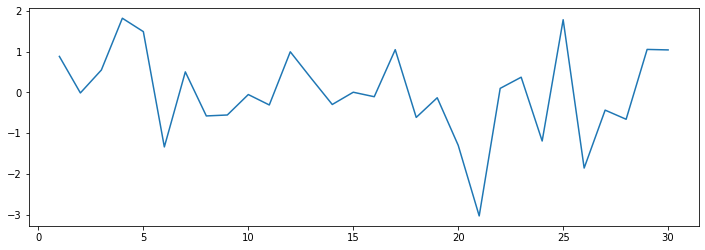

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(fitted_model.resid) + 1), fitted_model.resid)
plt.show()

These residuals look "random".

**(b)**

In [8]:
import statsmodels.api as sm

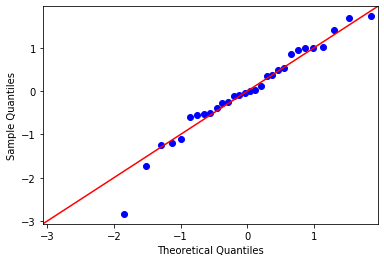

In [9]:
probplot = sm.ProbPlot(fitted_model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

The lower tail looks suspect; the plot otherwise looks sensible.  Doing a Shapiro-Wilk test to verify normality:

In [10]:
from scipy.stats import shapiro

In [11]:
W, p_value = shapiro(fitted_model.resid)
p_value

0.4845081865787506

Shapiro-Wilk fails to reject normality.

**(c)**

In [12]:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_with_bounds(acf, lower, upper, title='ACF'):
    max_k = len(acf)
    k = range(1, len(acf)+1)
    
    plt.figure(figsize=(12, 4))
    plt.fill_between(k, lower, upper, color='C0', alpha=0.2)

    plt.plot(k, acf, marker='o', linestyle='none', color='C0')
    plt.plot([1, max_k], [0, 0], ls=':', color='C0')
    for i_k, i_rho in zip(k, acf):
        plt.plot([i_k, i_k], [0, i_rho], color='C0')    
    
    plt.xlabel('Lag')
    plt.ylabel(r'$\rho_k$')
    plt.title(title)
    plt.show()

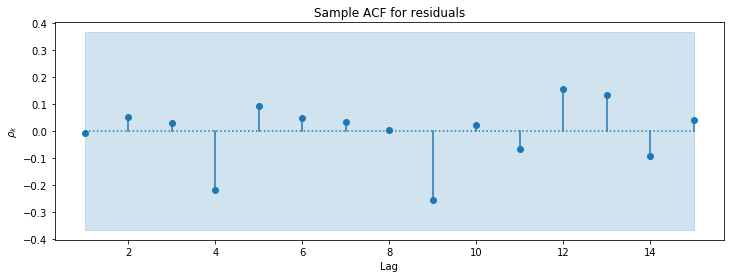

In [13]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

The sample ACF supports the residuals being random.

**(d)**

In [14]:
from scipy.stats import chi2

def ljung_box_test(r, n, k_ar=0, k_ma=0):
    nlags = len(r)
    denominators = np.arange(n-1, n-1-nlags, step=-1)
    Qstar = n * (n-2) * np.sum(r**2 / denominators)
    df = nlags - k_ar - k_ma
    p_value = 1 - chi2.cdf(Qstar, df=df)
    
    return {
        'X-squared': Qstar,
        'df': df,
        'p-value': p_value
    }

In [15]:
ljung_box_test(r=acf(fitted_model.resid, fft=False, nlags=8)[1:], n=len(Y), k_ar=1)

{'X-squared': 2.0225685691662245, 'df': 7, 'p-value': 0.9585806863868557}

The test does not reject randomness of error based on the first 8 autocorrelations.

**Exercise 8.5**. Simulate an MA(1) model with $n = 36$ and $\theta = −0.5$.

**(a)** Fit the correctly specified MA(1) model and look at a time series plot of the residuals.  Does the plot support the MA(1) specification?

**(b)** Display a normal quantile-quantile plot of the standardized residuals.  Does the plot support the MA(1) specification?

**(c)** Display the sample ACF of the residuals.  Does the plot support the MA(1) specification?

**(d)** Calculate the Ljung-Box statistic summing to K = 6.  Does this statistic support the MA(1) specification?

**Solution**.

In [16]:
np.random.seed(1000)
Y = generate_arima(theta=[-0.5], n=36)

**(a)**

In [17]:
fitted_model = ARIMA(Y, order=(0, 0, 1)).fit(method='mle')

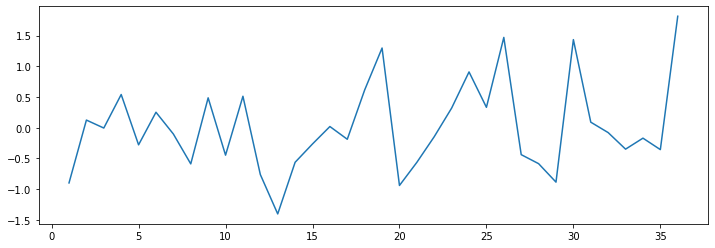

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(fitted_model.resid) + 1), fitted_model.resid)
plt.show()

These residuals look random.

**(b)**

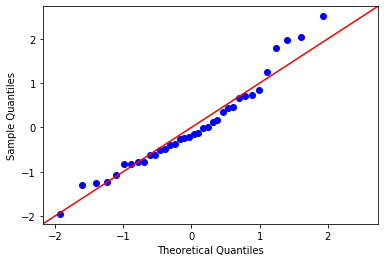

In [19]:
probplot = sm.ProbPlot(fitted_model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

The upper tail looks suspect, but the residuals do look random.  Doing a Shapiro-Wilk test to confirm:

In [20]:
W, p_value = shapiro(fitted_model.resid)
p_value

0.16901949048042297

Shapiro-Walk fails to reject normality.

**(c)**

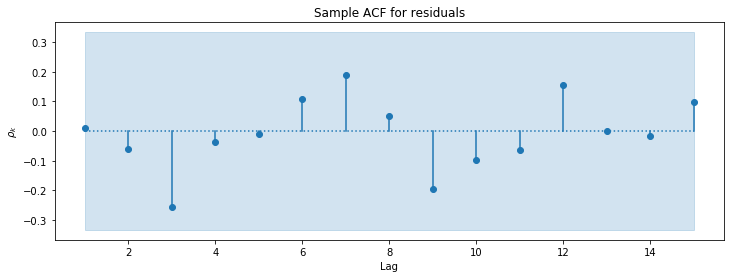

In [21]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

ACF supports residuals being random.

**(d)**

In [22]:
ljung_box_test(r=acf(fitted_model.resid, fft=False, nlags=6)[1:], n=len(Y), k_ma=1)

{'X-squared': 3.1238224861745865, 'df': 5, 'p-value': 0.680902808042148}

The test does not reject randomness of error based on the first 6 autocorrelations.

**Exercise 8.6**.  Simulate an AR(2) model with $n = 48$, $\phi_1 = 1.5$, and $\phi_2 = −0.75$.

**(a)** Fit the correctly specified AR(2) model and look at a time series plot of the residuals.  Does the plot support the AR(2) specification?

**(b)** Display a normal quantile-quantile plot of the standardized residuals.  Does the plot support the AR(2) specification?

**(c)** Display the sample ACF of the residuals.  Does the plot support the AR(2) specification?

**(d)** Calculate the Ljung-Box statistic summing to K = 12.  Does this statistic support the AR(2) specification?

**Solution**.

In [23]:
np.random.seed(2000)
Y = generate_arima(phi=[1.5, -0.75], n=48)

**(a)**

In [24]:
fitted_model = ARIMA(Y, order=(2, 0, 0)).fit(method='mle')

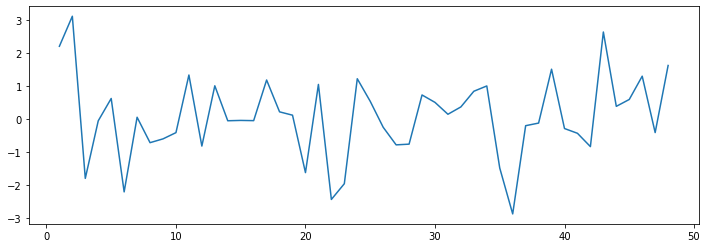

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(fitted_model.resid) + 1), fitted_model.resid)
plt.show()

The residuals look random.

**(b)**

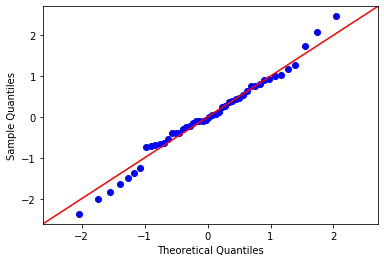

In [26]:
probplot = sm.ProbPlot(fitted_model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

Tails are a bit suspect in both directions.  Doing Shapiro-Wilk test for normality:

In [27]:
W, p_value = shapiro(fitted_model.resid)
p_value

0.8312253952026367

The test fails to reject normality in residuals.

**(c)**

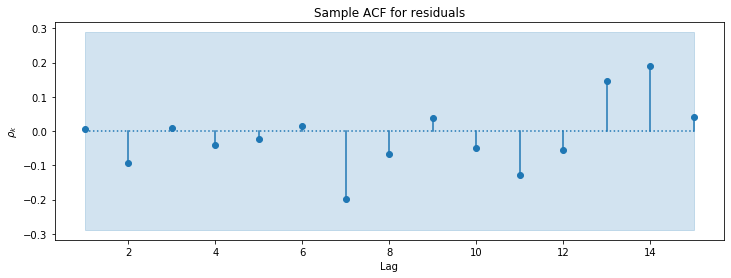

In [28]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

The ACF plot supports residuals being random.

**(d)**

In [29]:
ljung_box_test(r=acf(fitted_model.resid, fft=False, nlags=12)[1:], n=len(Y), k_ar=2)

{'X-squared': 4.33538315392091, 'df': 10, 'p-value': 0.9309516131660488}

The test does not reject randomness of error based on the first 12 autocorrelations.